# Emulator
I am using Gaussian Process to build an Emulator of FOM(Figure Of Merit). I have predicted a FOM value for last raw from given data.

In [1]:
import george
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from george import kernels
from scipy.optimize import minimize
from george.metrics import Metric
import matplotlib.cm as cm
%matplotlib inline

In [2]:
a = np.loadtxt("parameters_with_FOM.txt")
FOM = a[:,6]
a = a[:,:-1]

In [3]:
# area=14,300, depth=26.35, shear_m=0.003, sigma_z=0.05,  sig_delta_z=0.001,  sig_sigma_z=0.003

test1 = np.linspace(7000,20000, num=25) #area
test2 = np.linspace(25,27, num=25) #depth
#test2 = np.linspace(0.003,0.02, num=25) #shear_m
#test2 = np.linspace(0.01,0.1, num=25) #sig_z
#test2 = np.linspace(0.001,0.005, num=25) #sig_delta_z
#test2 = np.linspace(0.003,0.006, num=25) #sig_sigma_z
for param1 in test1:
    for param2 in test2:
        a = np.concatenate((a, [[param1, param2, 0.003, 0.05, 0.001, 0.003]]), axis=0)
Xtest = a[36:, 0]
Ytest = a[36:, 1]
Xtest = Xtest.reshape(25,25)
Ytest = Ytest.reshape(25,25)

In [4]:
#slicing up the array in 7 column array:
area = a[:,0]
depth = a[:,1]
shear_m = a[:,2]
sigma_z = a[:,3]
sig_delta_z = a[:,4]
sig_sigma_z= a[:,5]

In [5]:
#standardizing the data:
Sarea = (area-np.mean(area))/np.std(area)
Sdepth = (depth-np.mean(depth))/np.std(depth)
Sshear_m = (shear_m-np.mean(shear_m))/np.std(shear_m)
Ssigma_z = (sigma_z-np.mean(sigma_z))/np.std(sigma_z)
Ssig_delta_z = (sig_delta_z-np.mean(sig_delta_z))/np.std(sig_delta_z)
Ssig_sigma_z = (sig_sigma_z-np.mean(sig_sigma_z))/np.std(sig_sigma_z)
SFOM = (FOM-np.mean(FOM))/np.std(FOM)

In [6]:
#Putting together standardised parameter array:
x = np.column_stack([Sarea, Sdepth, Sshear_m, Ssigma_z, Ssig_delta_z, Ssig_sigma_z])
Sxtest = x[36:,:]
x = x[:36,:]

In [7]:
#creating a kernel-covariance in 6-D parameter space:
kernel = kernels.Product(kernels.ConstantKernel(log_constant=np.log((((2*np.pi)))**-0.5), ndim=6),
                         kernels.ExpSquaredKernel(metric= [1,1,1,1,1,1], ndim=6))

In [8]:
gp = george.GP(kernel, mean=np.mean(SFOM))

gp.compute(x)

In [9]:
#maximising likelihood:
def neg_ln_lik(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(SFOM) 
def grad_neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(SFOM) 

result = minimize(neg_ln_lik, gp.get_parameter_vector(), jac=grad_neg_ln_like)

gp.set_parameter_vector(result.x)

In [10]:
#Predicting the test point (it is the last raw of data here):
predSFOM,  Svariance = gp.predict(SFOM, Sxtest, return_var=True)

In [11]:
predFOM = predSFOM*np.std(FOM) + np.mean(FOM)
print(max(predFOM), min(predFOM))
predFOM = predFOM.reshape(25,25)
predFOM

50.694991388128386 17.699764038062785


array([[19.9028007 , 20.32080909, 20.74469834, 21.17246833, 21.60210899,
        22.03161598, 22.45900624, 22.88233328, 23.29970193, 23.70928247,
        24.10932404, 24.49816706, 24.87425463, 25.23614283, 25.58250972,
        25.91216306, 26.22404663, 26.51724513, 26.79098767, 27.04464982,
        27.27775417, 27.48996956, 27.68110892, 27.85112589, 28.00011015],
       [19.49831474, 19.94678296, 20.40121503, 20.85946024, 21.3193609 ,
        21.77876917, 22.23556385, 22.68766662, 23.13305787, 23.56979169,
        23.9960101 , 24.40995615, 24.80998592, 25.19457928, 25.56234923,
        25.91204981, 26.24258258, 26.55300145, 26.84251607, 27.11049354,
        27.35645875, 27.58009307, 27.78123167, 27.95985951, 28.11610598],
       [19.1176769 , 19.60060533, 20.08965441, 20.58250797, 21.07684521,
        21.57035882, 22.06077298, 22.54586079, 23.02346124, 23.49149516,
        23.94798041, 24.39104577, 24.81894367, 25.23006148, 25.62293132,
        25.99623835, 26.34882736, 26.67970774, 26

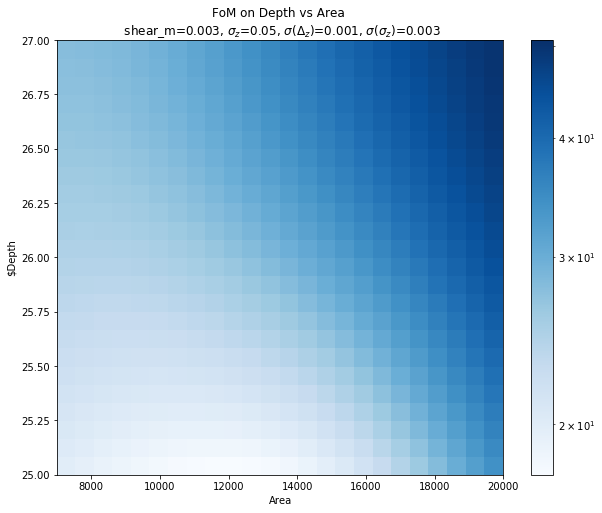

In [12]:
fig,ax = plt.subplots(figsize=(10,8))

norm = mpl.colors.LogNorm(vmin=17.699764038062785, vmax=50.694991388128386)

cs = ax.pcolormesh(Xtest, Ytest, predFOM, norm=norm, cmap=cm.Blues)
plt.title('FoM on Depth vs Area \n shear_m=0.003, $\sigma_z$=0.05, $\sigma (\Delta_z)$=0.001, $\sigma (\sigma_z)$=0.003')
plt.xlabel('Area')
plt.ylabel('$Depth')

formatter = mpl.ticker.ScalarFormatter()
fig.colorbar(cs, cmap=cm.Blues, norm=norm, format=formatter)
plt.savefig('FOM-DepthvsArea.png',dpi=500)
plt.show()